In [1]:
import random as rd
import numpy as np
from itertools import product
from scipy import optimize
import datetime
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
#Generating pairwise correlations of 10 sectors
M2_S = np.zeros((10,10))
for i,j in product (range(0,10),range(0,10)):
    if (i==j):
        M2_S[i][j] = 1.0
    else:
        if (i>j):
            M2_S[i][j] = rd.uniform(-1.0,1.0)
            M2_S[j][i] = M2_S[i][j]   

In [2]:
#Correlation matrix of 100 stocks based on their sector structure

def tanh(x):
    for (k,i,j) in product(range(0,61), range(0,100), range(0,100)):
        x[k][i][j] = np.tanh(x[k][i][j])


def daily_correlation(sigma):
    daily_corr = np.zeros((61, 100, 100))
    for (i, j) in product (range(0,100), range(0,100)):
        if (i>j):
            daily_corr[0][i][j] = np.random.normal(M2_S[i/10][j/10], sigma, 1)
            daily_corr[0][j][i] = daily_corr[0][i][j]
        else:
            if (i==j):
                daily_corr[0][i][j] = 1.0
        for k in range(1, 61):
            if (i>j):
                daily_corr[k][i][j] = np.random.normal(daily_corr[k-1][i][j], sigma, 1)
                daily_corr[k][j][i] = daily_corr[k][i][j]
            else:
                if (i==j):
                    daily_corr[k][i][j] = 1.0  
    tanh(daily_corr)
    return daily_corr

daily_corr = daily_correlation(0.3)




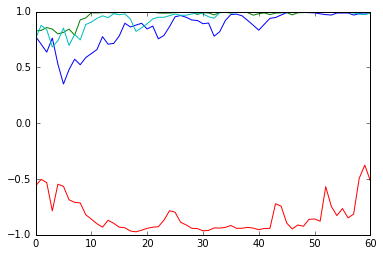

In [3]:
 #Plots showing evolution of the correlations between some stocks
def plots(daily_corr):       
    a,b,c,d = [],[],[],[]
    for i in range (0,61):
        a.append(daily_corr[i][9][94])
        b.append(daily_corr[i][97][95])
        c.append(daily_corr[i][10][11])
        d.append(daily_corr[i][10][12])

    plt.plot(a, 'r', b, 'b', c, 'g', d, 'c')
    plt.show()

    
plots(daily_corr)

In [4]:
#Generating samples of stock returns based on their correlations over 61 days
def return_generator(N_samples, daily_corr):
    mu = np.zeros(100)
    returns = []
    for k in range(0,61):
        returns.append(np.random.multivariate_normal(mu, daily_corr[k], N_samples))
    last_returns = returns[60]
    returns = np.swapaxes(np.delete(returns, 60, axis=0), 0, 1)
    return returns, last_returns

In [5]:
#Empirical models for correlation matrices of stock returns constructed from 60 days
#model1 - straight-forward empirical
#model2 - with respect to the knowledge of underlying sector structure
#r1 - sample returns on the 61st day
def empiric_models(N_samples, daily_corr):
    r0, r1 = return_generator(N_samples, daily_corr)
    model1 = []
    model2 = np.zeros((N_samples, 100, 100))
    sector_average_corr = np.zeros((N_samples, 10, 10))
    for k in range(0, N_samples):
        model1.append(np.corrcoef(r0[k].transpose()))
        for (i,j) in product(range(0,10), range(0,10)):         
            if (i>j):
                sector_average_corr[k][i][j] = np.mean(model1[k][i*10:(i+1)*10, j*10:(j+1)*10])
                sector_average_corr[k][j][i] = sector_average_corr[k][i][j]
            else:
                if (i==j):
                    sector_average_corr[k][i][j] = (np.sum(model1[k][i*10:(i+1)*10, j*10:(j+1)*10])-10)/90
        for (i,j) in product(range(0,100), range(0,100)):
            if (i==j):
                model2[k][i][j] = 1.0
            else:
                model2[k][i][j] = sector_average_corr[k][i/10][j/10]
    return model1, model2, r1
    


In [6]:
#Weights for standard minimum variance Markowitz portfolio
bnds = []
for i in range(0,100):
    bnds.append((0, None))
bnds = tuple(bnds)
cons_sum = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})
def portfolio_variance(x, matrix):
    p_var = np.dot(np.dot(x, matrix), x)
    return p_var
def grad_portfolio_var(x, matrix):
    grad = []
    for i in range(0,100):
        s = np.dot(matrix[i], x)+matrix[i][i]*x[i]
        grad.append(s)
    return grad
def weights(matrix, number_of_weights):
    x0 = (1./number_of_weights)*np.ones(number_of_weights)
    res = optimize.minimize(portfolio_variance, x0, args=(matrix), method = 'SLSQP',
                            jac = grad_portfolio_var, bounds=bnds, constraints=cons_sum,
                            options={'maxiter': 100})
    return res.x

In [7]:
#Error function for sample/out_of_sample as variance of optimal portfolio returns
#range_of_sample - range on which we estimate optimal weights
#out_of_sample range is set to be 200
N_samples = 1200
m2 = np.identity(100)
def error(x, sample_or_not, range_of_sample):
    if (sample_or_not=='sample'):
        boundary0 = 1000 - range_of_sample
        boundary1 = 1000
    if (sample_or_not=='out_of_sample'):
        boundary0 = 1000
        boundary1 = 1200
    portfolio_returns = []
    for k in range (boundary0, boundary1):
        m = x[0]*m0[k] + x[1]*m1[k] + (1-x[0]-x[1])*m2
        w = weights(m, 100)
        portfolio_returns.append(np.dot(w, r1[k]))
    return np.var(portfolio_returns)

In [8]:
#Optimizing model weights with positivity constraints 
#Function depending on the range_of_sample
cons = ({'type': 'ineq', 'fun': lambda x: x[0]},
       {'type': 'ineq', 'fun': lambda x: x[1]},
       {'type': 'ineq', 'fun': lambda x: 1-x[0]-x[1]})
def optimal_model_weights(a):
    x0 = [0.5, 0.3]
    start_time = datetime.datetime.now()
    res = optimize.minimize(error, x0, args=('sample', a), method='COBYLA',
                       constraints=cons,
                       options={'maxiter': 100})
    return datetime.datetime.now() - start_time, res.x, res.fun


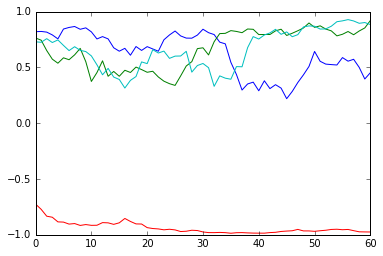

C:\Users\Mikhail\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: covariance is not positive-semidefinite.
C:\Users\Mikhail\Anaconda2\lib\site-packages\scipy\optimize\slsqp.py:337: RuntimeWarning: invalid value encountered in greater
  bnderr = where(bnds[:, 0] > bnds[:, 1])[0]


0:00:28.638000 [ 0.28346782  0.71206705] 0.00201811181895
0.00530752385568


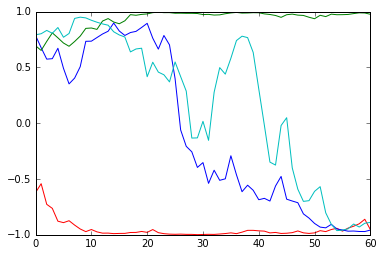

0:00:17.968000 [  9.99450887e-01   5.49112610e-04] 0.0117795610381
0.0257809609607


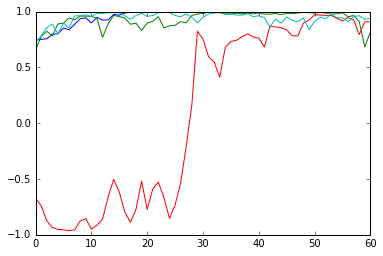

0:00:08.086000 [ 0.12356728  0.10543869] 0.00960786495931
0.0292816827359


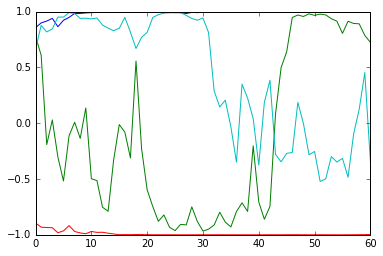

0:00:07.492000 [ 0.41204792  0.26742211] 0.0157159345806
0.024348806533


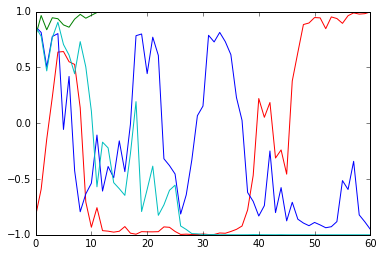

0:00:15.888000 [ 0.38272473  0.61727527] 0.00752598477975
0.0378892248589


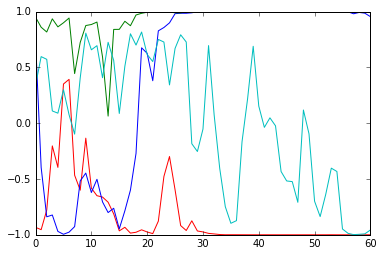

0:00:10.758000 [ 0.75896465  0.24103535] 0.0134975708662
0.0270381549017


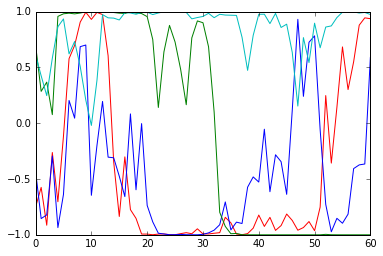

0:00:07.185000 [  1.00000000e+00  -5.55111512e-17] 0.0309468499685
0.0425523614926


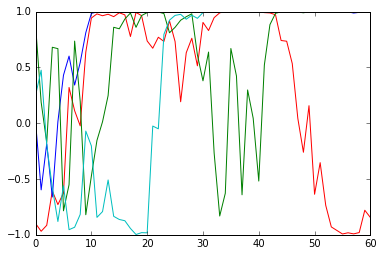

0:00:10.368000 [ 0.56303704  0.        ] 0.0147190848984
0.031213977281


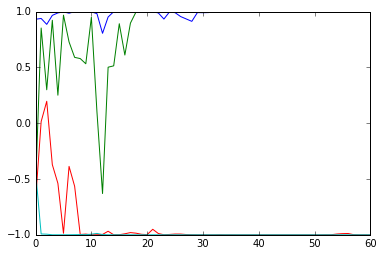

0:00:12.935000 [ 0.58035919  0.41964081] 0.0429963828676
0.038668582199


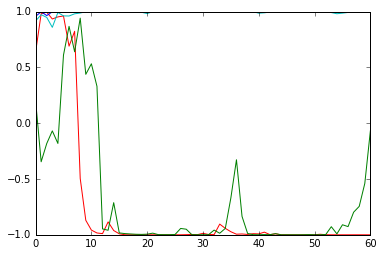

0:00:10.602000 [  8.77397266e-01  -4.93038066e-32] 0.0296379727526
0.0477190989517


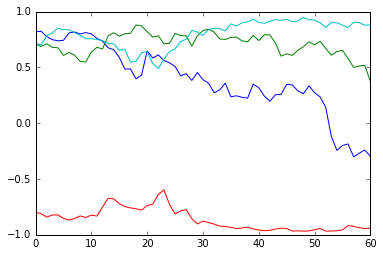

0:00:58.174000 [ 0.2642973  0.7357027] 0.0021010685612
0.00789874079779


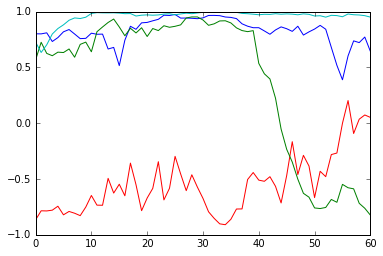

0:00:44.384000 [ 0.97538412  0.02461588] 0.0191090248172
0.0214632006722


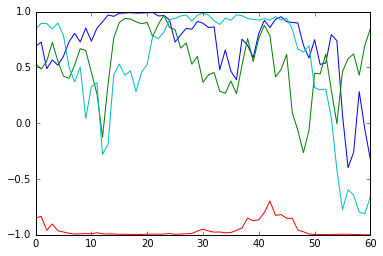

0:00:35.438000 [ 0.37077811  0.62922189] 0.00624247579516
0.0164147087015


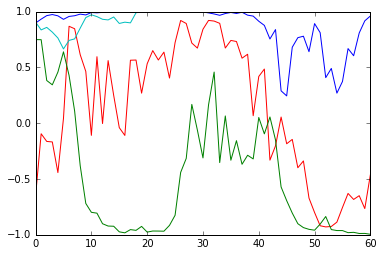

0:00:32.714000 [ 0.86797488  0.13202512] 0.0228863749994
0.0512036918144


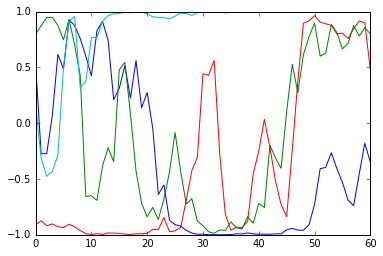

0:00:28.092000 [ 0.7475716  0.2524284] 0.0235943109961
0.0261154258219


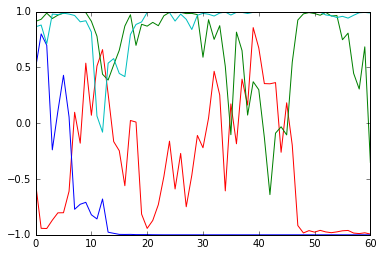

0:00:21.447000 [ 0.99664925  0.00335075] 0.0307059743009
0.0383362463012


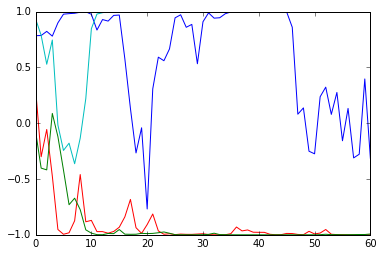

0:00:18.128000 [ 0.35047568  0.47642524] 0.0283442534867
0.043762317236


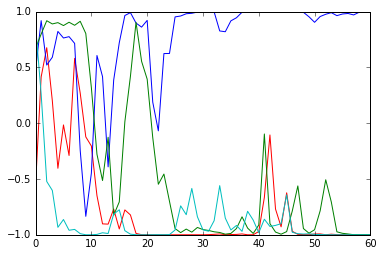

0:00:15.324000 [  1.00000000e+00  -4.16333634e-17] 0.0165493862084
0.0416163692704


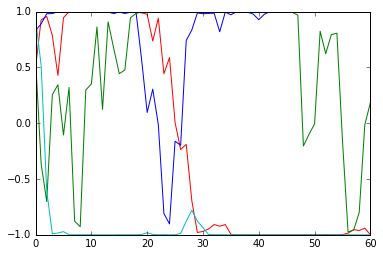

0:00:15.144000 [  1.00000000e+00  -4.16333634e-17] 0.0267043213434
0.037424485886


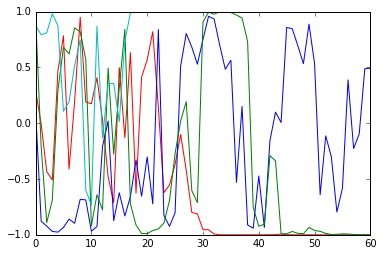

0:00:12.495000 [  1.00000000e+00   2.77555756e-17] 0.0298855097848
0.0364994624793


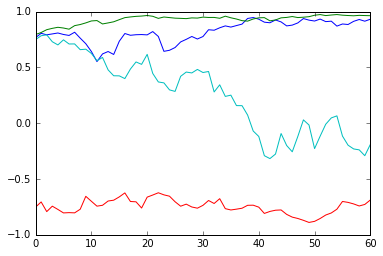

0:02:57.236000 [ 0.33857037  0.66128821] 0.00707021112331
0.00793891052059


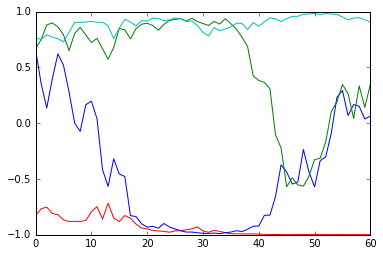

0:01:31.724000 [ 0.99579027  0.00103733] 0.0154057963841
0.0254983148024


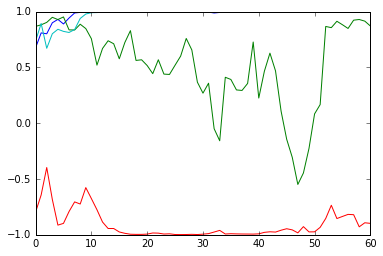

0:01:38.149000 [ 0.83956374  0.16031358] 0.0355517919189
0.0320699690101


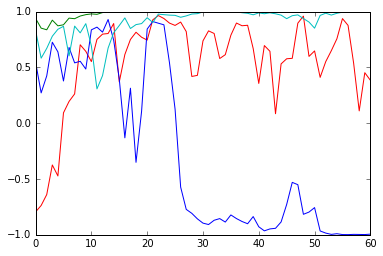

0:01:24.322000 [ 0.64824365  0.35175635] 0.0289120816528
0.0298447654284


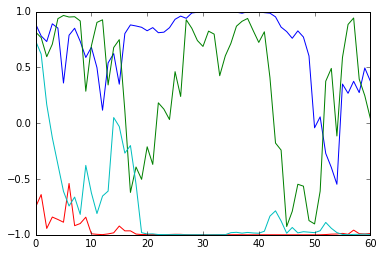

0:01:08.973000 [  9.83649677e-01   9.59763109e-05] 0.0382819506123
0.0469491814247


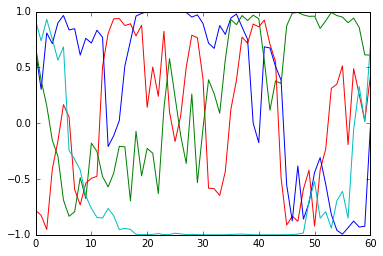

0:00:38.786000 [  1.00000000e+00  -4.16333634e-17] 0.0342442701125
0.0284183417455


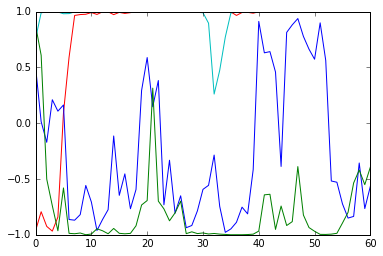

0:01:00.772000 [ 0.39283171  0.58113528] 0.0344339255566
0.0353927677845


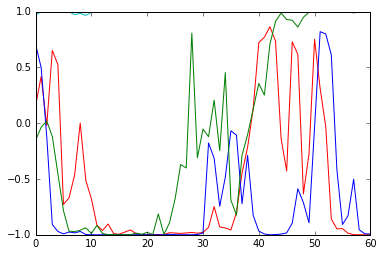

0:01:19.463000 [ 0.9114164   0.08787822] 0.0446885031894
0.0364381458123


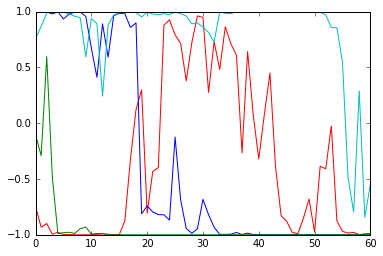

0:00:38.005000 [  1.00000000e+00  -4.16333634e-17] 0.0382630974975
0.0648625692941


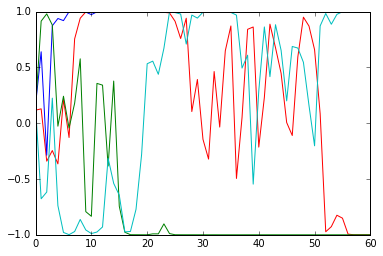

0:00:58.564000 [ 0.21602884  0.73220042] 0.0261272074272
0.0321036531356


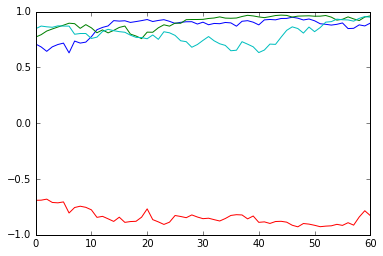

0:05:11.372000 [ 0.37503806  0.62483745] 0.00873170315492
0.00789822434304


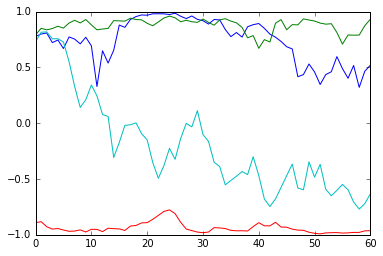

0:04:08.055000 [ 0.72578669  0.2740719 ] 0.0169572067896
0.0217086400686


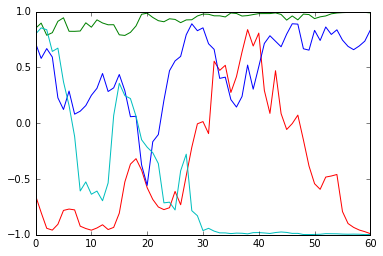

0:02:57.800000 [ 0.85849628  0.11428805] 0.0188138016759
0.0245427993698


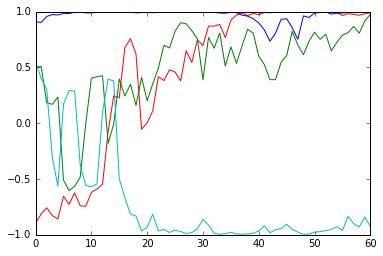

0:02:06.932000 [ 0.45368401  0.52066046] 0.0307893948108
0.0288449859954


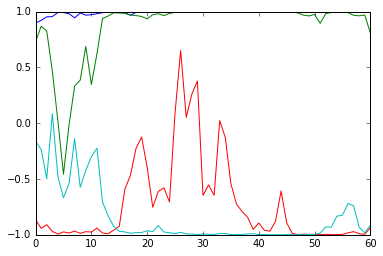

0:01:42.017000 [ 0.49834345  0.29905132] 0.0483336497591
0.0366491669684


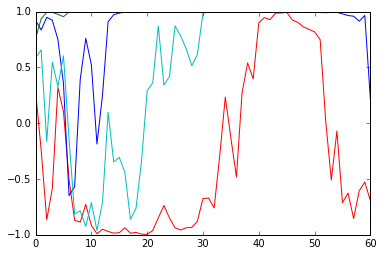

0:02:30.033000 [ 0.78624075  0.21375925] 0.0418022428067
0.0489986174469


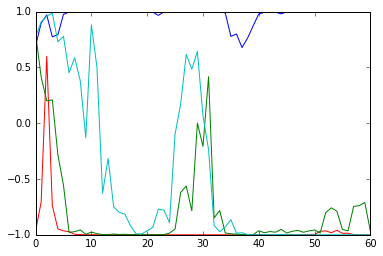

0:02:16.699000 [ 0.66038354  0.32626482] 0.0469463504749
0.0294165246259


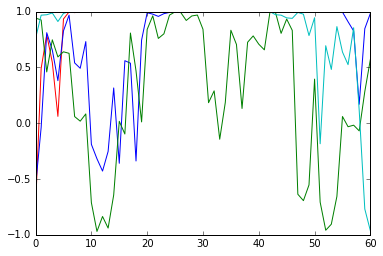

0:02:21.800000 [ 0.6453401  0.3546599] 0.0441645747101
0.0406954464228


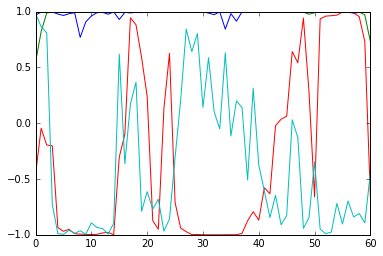

0:02:18.395000 [ 0.99748121  0.00251879] 0.0489884329462
0.0415900438013


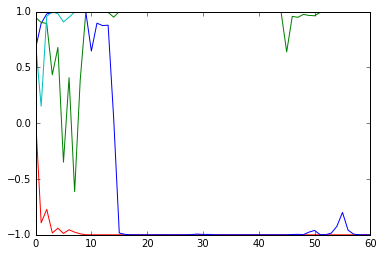

0:02:27.562000 [ 0.64223269  0.35776731] 0.028533740679
0.0336962659492


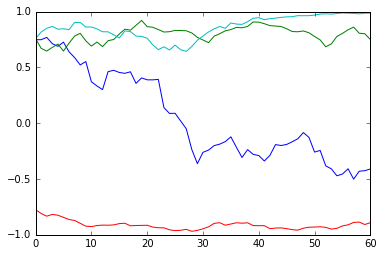

0:11:07.228000 [ 0.35275754  0.64724246] 0.0102965242962
0.0109564812758


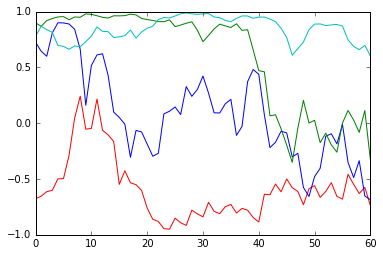

0:08:01.794000 [ 0.61419536  0.38580464] 0.0208446475945
0.0194250608128


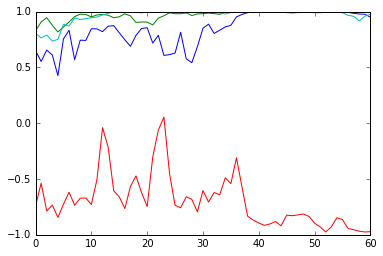

0:06:07.869000 [ 0.42547974  0.57437905] 0.020136151104
0.0233518029879


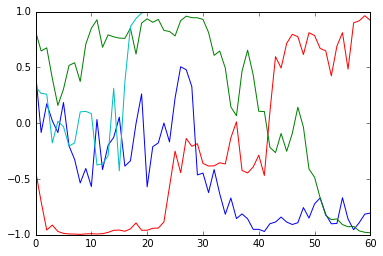

0:05:29.937000 [ 0.71420847  0.28579153] 0.0248443816386
0.018120017827


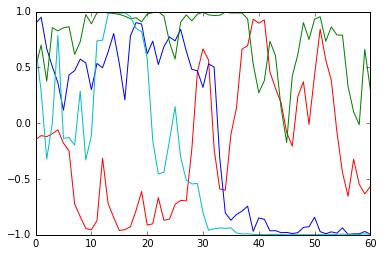

0:05:14.044000 [ 0.94455344  0.05544656] 0.0282711591049
0.0298757963714


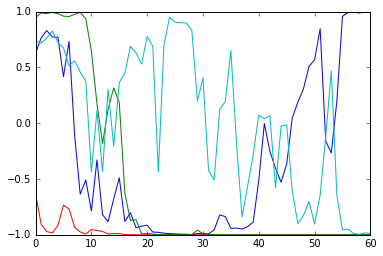

0:03:48.701000 [  9.99681802e-01   3.18198052e-04] 0.0331935316055
0.0371553581149


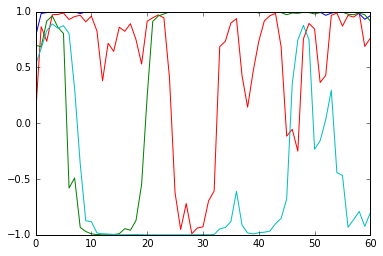

0:04:17.742000 [ 0.67552355  0.32405749] 0.0245756106031
0.0318926547697


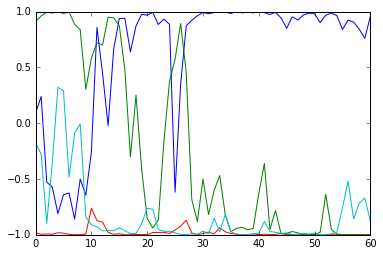

0:03:07.539000 [ 0.53859158  0.36542352] 0.0390259348321
0.0412780191444


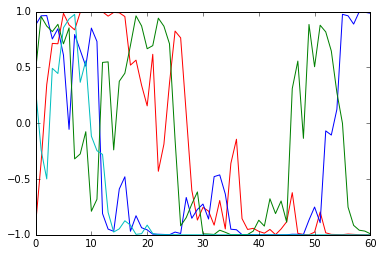

0:03:46.459000 [  9.99615234e-01   3.84765526e-04] 0.0307238738809
0.0308244203382


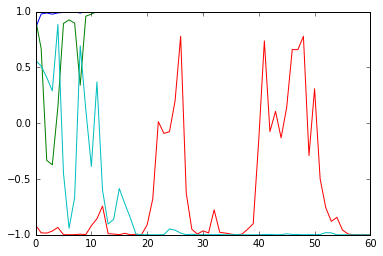

0:04:55.737000 [ 0.87770478  0.12229522] 0.0444377684104
0.0460481693162


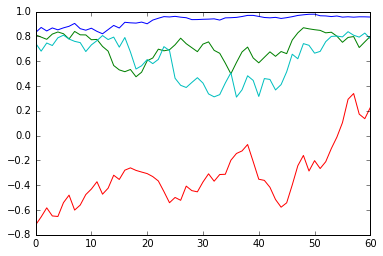

0:23:36.082000 [ 0.46942558  0.53057243] 0.00697181647955
0.00752076927138


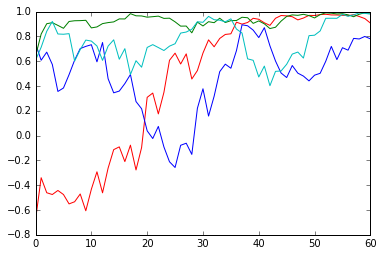

0:19:15.392000 [ 0.43114143  0.56885857] 0.0177620475593
0.0177603651495


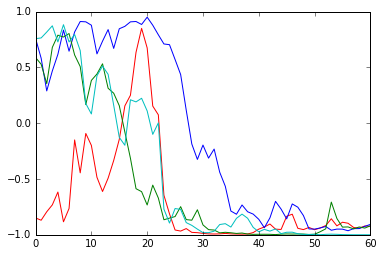

0:16:54.683000 [ 0.92107528  0.07892472] 0.0289319370139
0.0300549310715


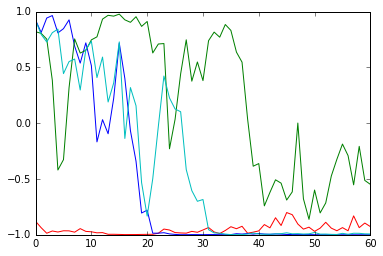

0:15:01.443000 [ 0.79049365  0.20950635] 0.0280656268907
0.0380185456222


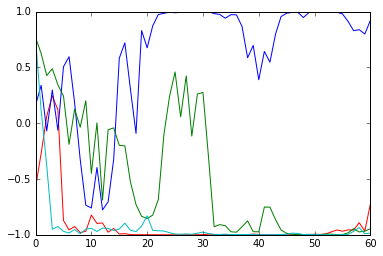

0:14:41.284000 [ 0.8330322  0.1669678] 0.0334085954469
0.0366180280473


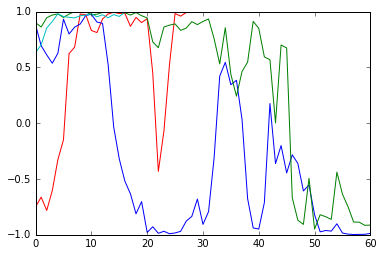

0:11:32.535000 [ 0.63419105  0.358193  ] 0.0235731233223
0.0275733719911


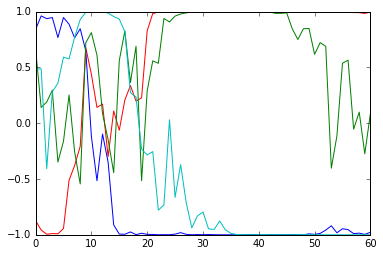

0:10:12.156000 [ 0.70125403  0.29846416] 0.0512207532544
0.0333360646948


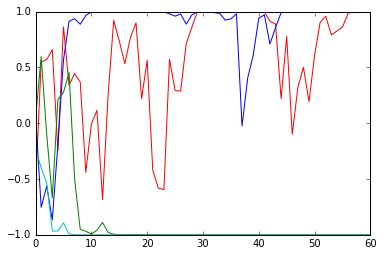

0:11:22.147000 [ 0.88978912  0.11021088] 0.0255572174388
0.0219677855113


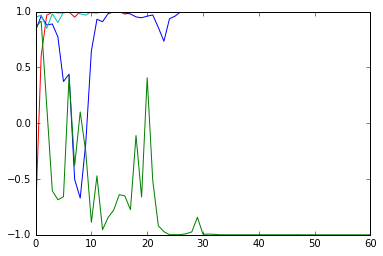

0:11:09.446000 [ 0.99351064  0.00648936] 0.0410432434963
0.0427915524964


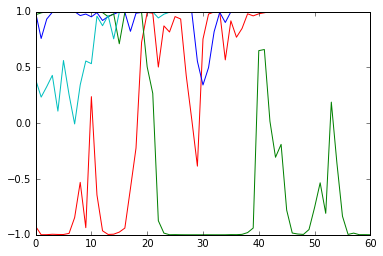

0:10:57.057000 [ 0.86922896  0.10179625] 0.0277105490535
0.0314984040031


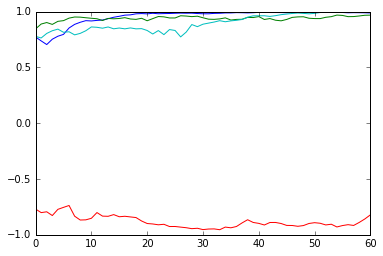

0:55:53.573000 [ 0.46100703  0.53899297] 0.00790612036828
0.00792776757629


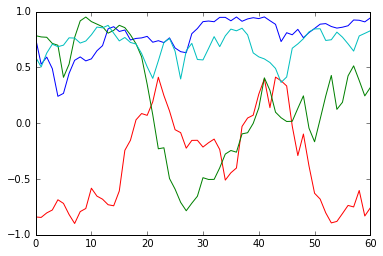

0:38:44.527000 [ 0.49240667  0.50751517] 0.0174121625404
0.017495215126


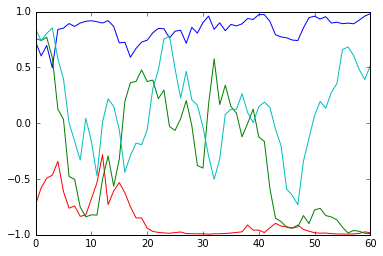

0:28:47.994000 [ 0.5575161   0.44148835] 0.0225926874509
0.0232110928254


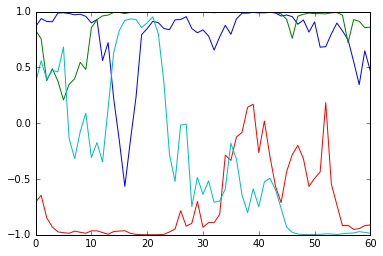

0:27:24.798000 [ 0.60495333  0.39504667] 0.026873359399
0.026881942479


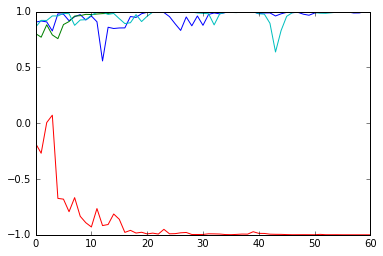

0:24:00.106000 [ 0.77288504  0.22711496] 0.0275837417469
0.0254869120191


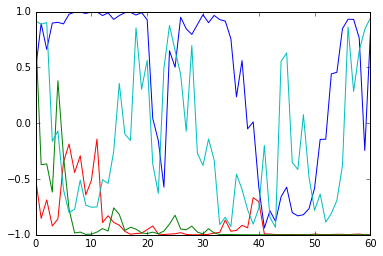

0:20:00.239000 [ 0.54263496  0.30451587] 0.0455965591923
0.044674320504


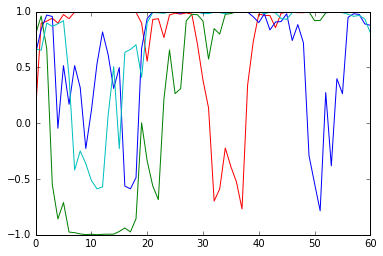

0:20:58.348000 [ 0.70789579  0.15136389] 0.0281947205492
0.0327271447417


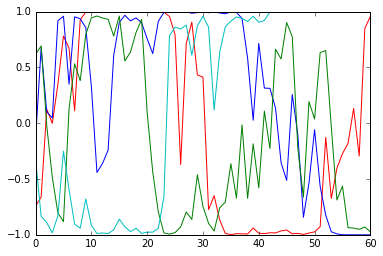

0:13:22.331000 [  1.00000000e+00   1.11022302e-16] 0.0287318011437
0.0367582775732


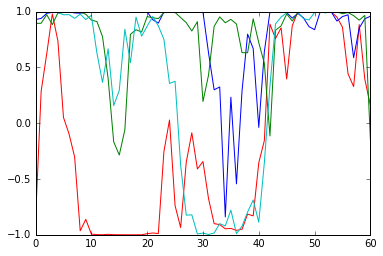

0:23:29.157000 [ 0.59083523  0.40909884] 0.0342912566206
0.0297062260247


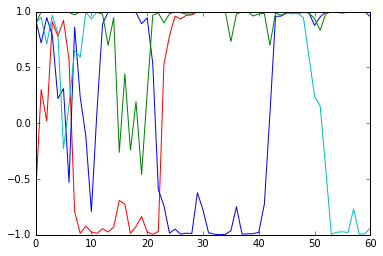

0:20:26.986000 [ 0.82739008  0.17260992] 0.0289026061192
0.0292959196648


In [9]:
times = []
results = []
sample_error = []
out_of_sample_error = []
sigma_values = np.linspace(0.1, 1.0, 10)
range_of_sample = [10, 20, 50, 100, 200, 500, 1000]
for i in range_of_sample:
    local_results, local_sample_error, local_times, local_out_of_sample_error = [], [], [], []
    for sigma in sigma_values:
        daily_corr = daily_correlation(sigma)
        plots(daily_corr)
        m0, m1, r1 = empiric_models(N_samples, daily_corr)
        time, result, err = optimal_model_weights(i)
        local_sample_error.append(err)
        local_results.append([result[0], result[1], 1-result[0]-result[1]])
        local_times.append(time)
        print time, result, err
        e = error(result, 'out_of_sample', 100)
        print e
        local_out_of_sample_error.append(e)
    results.append(local_results)
    times.append(local_times)
    sample_error.append(local_sample_error)
    out_of_sample_error.append(local_out_of_sample_error)



In [10]:
print times
print results
print sample_error
print out_of_sample_error


[[datetime.timedelta(0, 28, 638000), datetime.timedelta(0, 17, 968000), datetime.timedelta(0, 8, 86000), datetime.timedelta(0, 7, 492000), datetime.timedelta(0, 15, 888000), datetime.timedelta(0, 10, 758000), datetime.timedelta(0, 7, 185000), datetime.timedelta(0, 10, 368000), datetime.timedelta(0, 12, 935000), datetime.timedelta(0, 10, 602000)], [datetime.timedelta(0, 58, 174000), datetime.timedelta(0, 44, 384000), datetime.timedelta(0, 35, 438000), datetime.timedelta(0, 32, 714000), datetime.timedelta(0, 28, 92000), datetime.timedelta(0, 21, 447000), datetime.timedelta(0, 18, 128000), datetime.timedelta(0, 15, 324000), datetime.timedelta(0, 15, 144000), datetime.timedelta(0, 12, 495000)], [datetime.timedelta(0, 177, 236000), datetime.timedelta(0, 91, 724000), datetime.timedelta(0, 98, 149000), datetime.timedelta(0, 84, 322000), datetime.timedelta(0, 68, 973000), datetime.timedelta(0, 38, 786000), datetime.timedelta(0, 60, 772000), datetime.timedelta(0, 79, 463000), datetime.timedelta

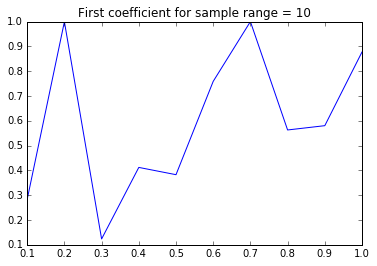

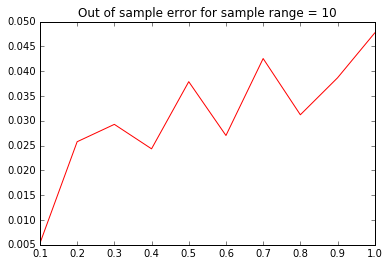

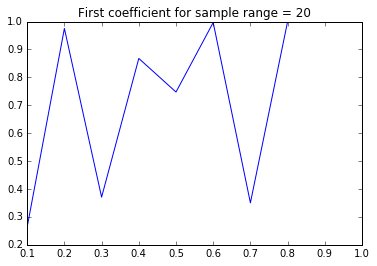

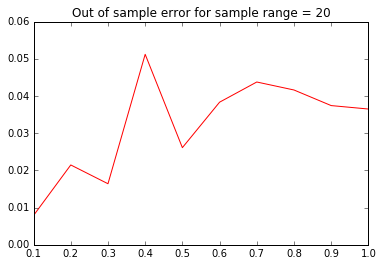

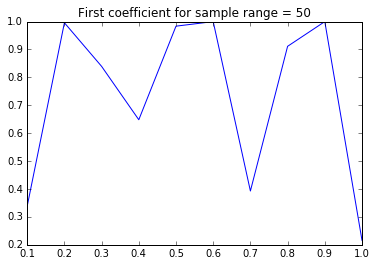

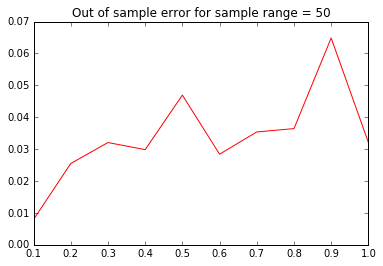

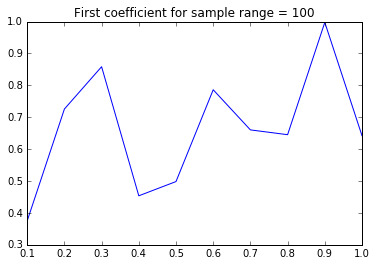

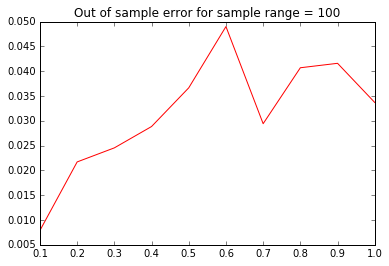

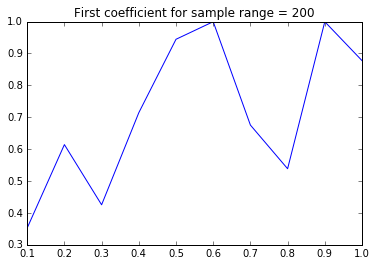

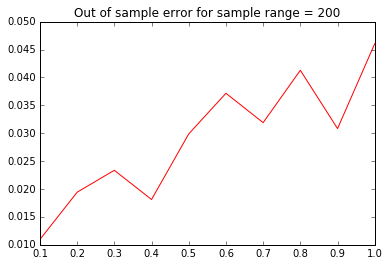

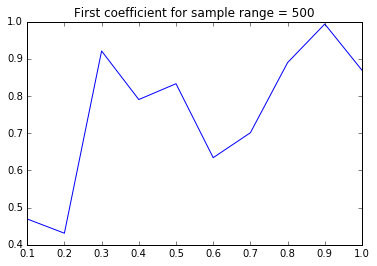

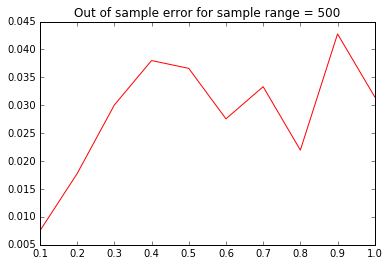

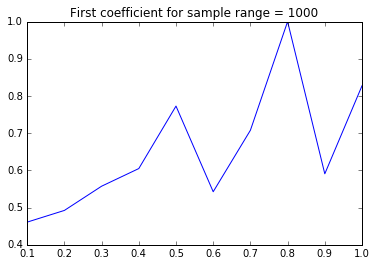

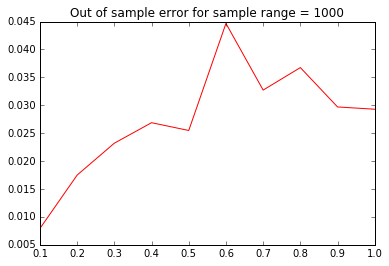

In [24]:
for i in range(0,7):
    a, b = [], []
    for j in range (0,10):
        a.append(results[i][j][0])
        b.append(out_of_sample_error[i][j])
    plt.plot(sigma_values, a, 'b')
    plt.title('First coefficient for sample range = %d' % range_of_sample[i])
    plt.show()
    plt.plot(sigma_values, b, 'r')
    plt.title('Out of sample error for sample range = %d' % range_of_sample[i])
    plt.show()


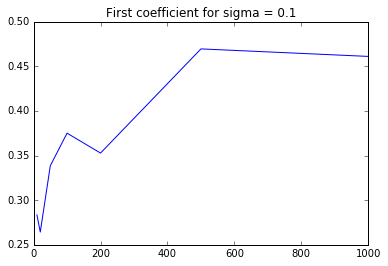

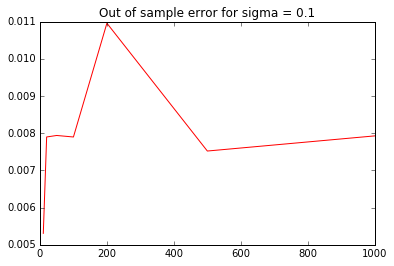

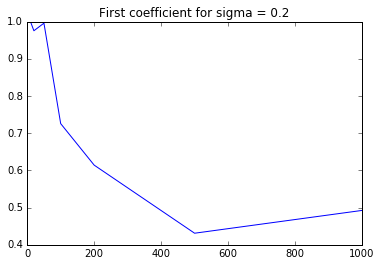

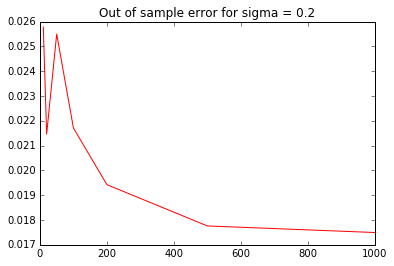

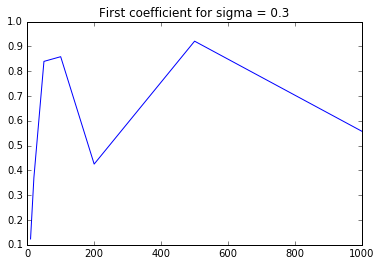

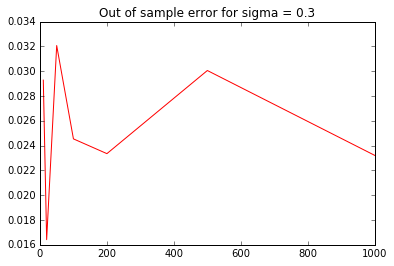

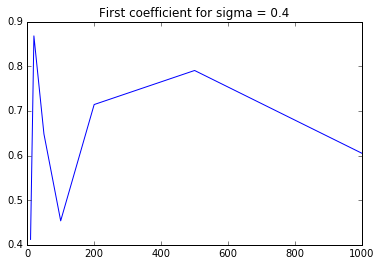

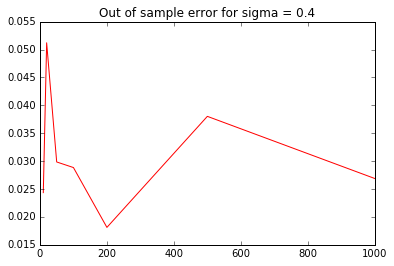

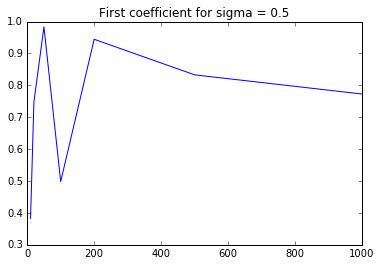

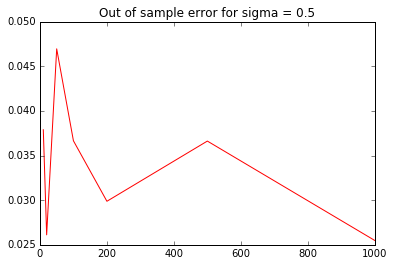

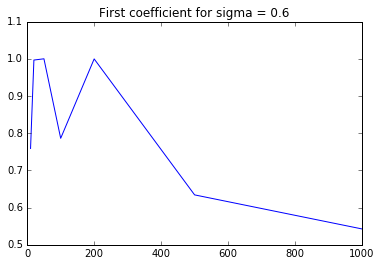

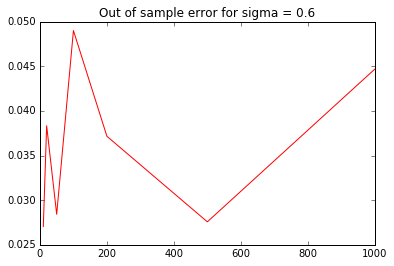

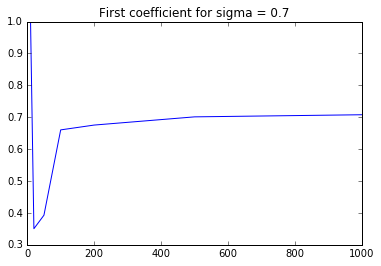

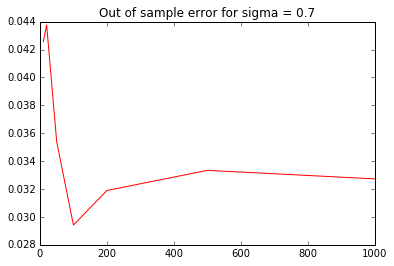

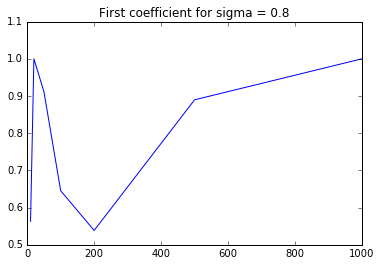

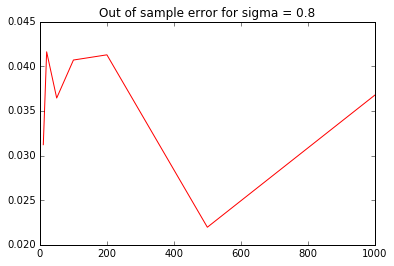

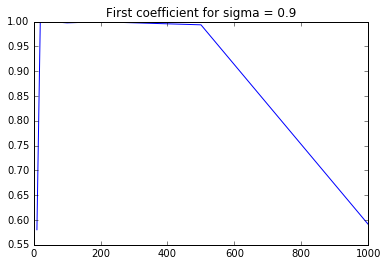

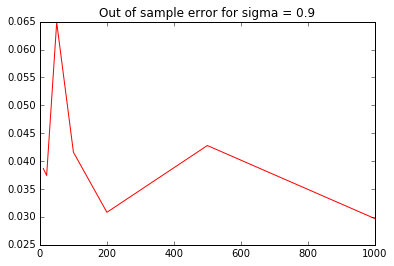

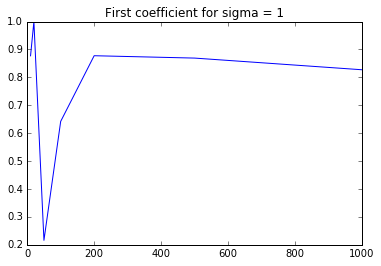

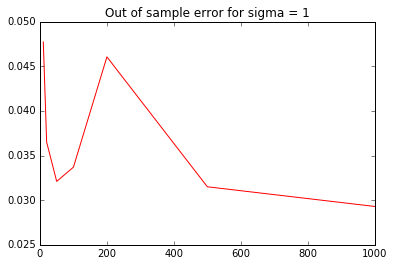

In [26]:
for i in range(0,10):
    a, b = [], []
    for j in range(0,7):
        a.append(results[j][i][0])
        b.append(out_of_sample_error[j][i])
    plt.plot(range_of_sample, a, 'b')
    plt.title('First coefficient for sigma = %lg' % sigma_values[i])
    plt.show()
    plt.plot(range_of_sample, b, 'r')
    plt.title('Out of sample error for sigma = %lg' % sigma_values[i])
    plt.show()

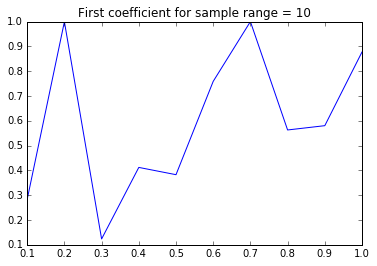

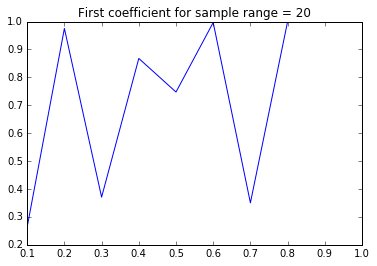

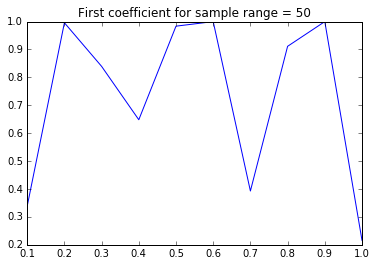

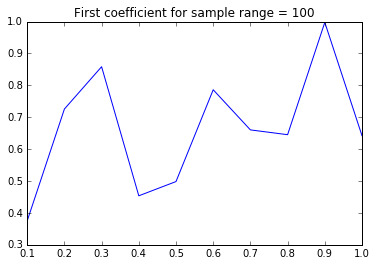

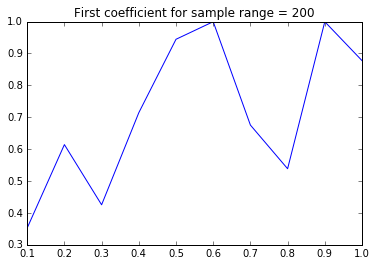

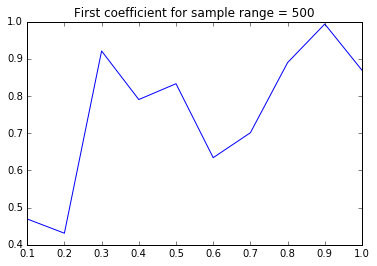

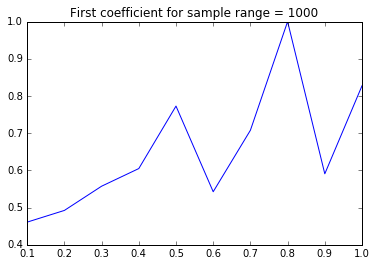

In [28]:
for i in range(0,7):
    a = []
    for j in range (0,10):
        a.append(results[i][j][0])
    plt.plot(sigma_values, a, 'b')
    plt.title('First coefficient for sample range = %d' % range_of_sample[i])
    plt.show()

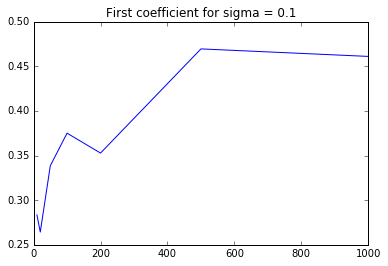

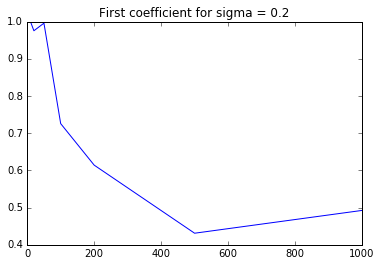

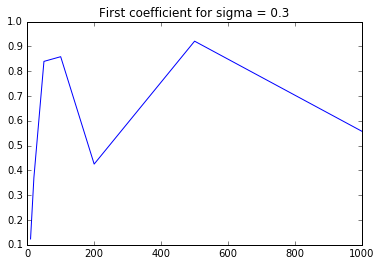

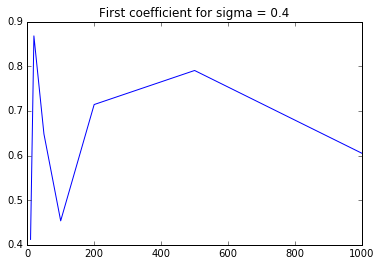

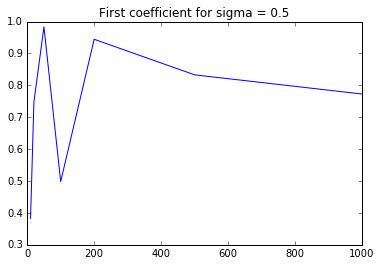

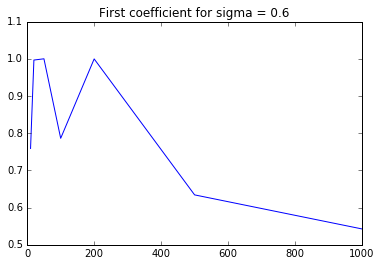

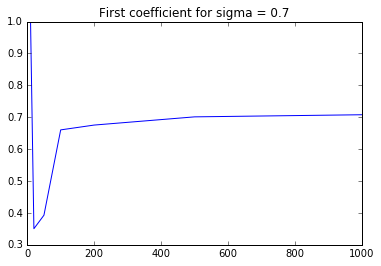

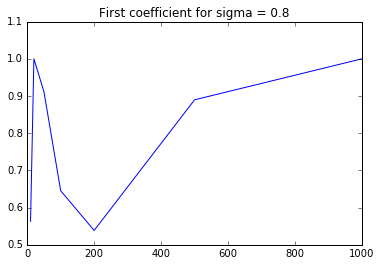

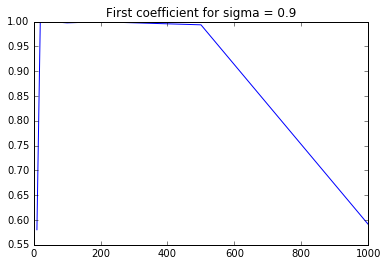

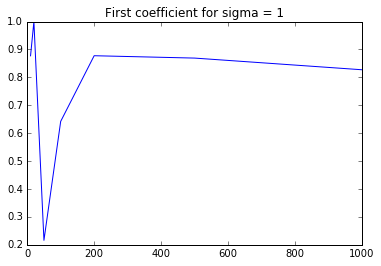

In [29]:
for i in range(0,10):
    a = []
    for j in range(0,7):
        a.append(results[j][i][0])
    plt.plot(range_of_sample, a, 'b')
    plt.title('First coefficient for sigma = %lg' % sigma_values[i])
    plt.show()